In [117]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt 
import string
import os
from PIL import Image
import random, pickle
import glob
from pickle import dump, load
from tqdm.notebook import tqdm
from time import time
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, Add
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Bidirectional, add
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from nltk.tokenize import RegexpTokenizer

In [118]:
def load_and_process_descriptions(desc_file):
    def load_doc(filename):
        with open(filename, 'r') as file:
            return file.read()
    
    def load_descriptions(doc):
        mapping = dict()
        for line in doc.split('\n'):
            if len(line) < 2: continue
            tokens = line.split()
            image_id, image_desc = tokens[0], tokens[1:]
            image_id = image_id.split('.')[0]
            image_desc = ' '.join(image_desc)
            if image_id not in mapping:
                mapping[image_id] = list()
            mapping[image_id].append(image_desc)
        return mapping
    
    def clean_descriptions(descriptions):
        tokenizer = RegexpTokenizer(r'\w+')
        table = str.maketrans('', '', string.punctuation)
        for key, desc_list in descriptions.items():
            for i in range(len(desc_list)):
                desc = desc_list[i]
                desc = tokenizer.tokenize(desc)
                desc = [word.lower() for word in desc]
                desc = [word for word in desc if len(word) > 1]
                desc_list[i] = ' '.join(desc)
    
    doc = load_doc(desc_file)
    descriptions = load_descriptions(doc)
    clean_descriptions(descriptions)
    return descriptions

In [119]:
def get_vocabulary(descriptions):
    tokenizer = RegexpTokenizer(r'\w+')
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(tokenizer.tokenize(d)) for d in descriptions[key]]
    return all_desc

# Save descriptions
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [120]:
def setup_feature_extractor():
    model = InceptionV3(weights='imagenet')
    return Model(model.input, model.layers[-2].output)

def encode_image(image_path, model):
    """Encode single image"""
    def preprocess(image_path):
        img = image.load_img(image_path, target_size=(299, 299))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        return preprocess_input(x)
    
    img = preprocess(image_path)
    return model.predict(img, verbose=0)

def encode_images(image_paths, model):
    encoded = {}
    for img_path in tqdm(image_paths, desc="Encoding images"):
        encoded[os.path.basename(img_path)] = encode_image(img_path, model)
    return encoded

In [121]:
def prepare_text_data(descriptions):
    """Create tokenizer and vocabulary"""
    all_captions = []
    for key, val in descriptions.items():
        all_captions.extend(val)
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    vocab_size = len(tokenizer.word_index) + 1
    max_length = max(len(cap.split()) for cap in all_captions)
    
    return tokenizer, vocab_size, max_length


In [122]:
def encode_images_to_disk(image_paths, model, output_path="image_features.pkl"):
    encoded = {}
    for img_path in tqdm(image_paths, desc="Encoding images"):
        img_id = os.path.basename(img_path)
        feature = encode_image(img_path, model)
        encoded[img_id] = feature.squeeze()  # Flatten to 1D
    with open(output_path, 'wb') as f:
        pickle.dump(encoded, f)
    return encoded

def load_encoded_images(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

In [123]:
class CaptionDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, descriptions, photos, wordtoix, max_length, batch_size=4):
        self.descriptions = {k: descriptions[k] for k in descriptions if k in photos}
        self.photos = photos
        self.wordtoix = wordtoix
        self.max_length = max_length
        self.batch_size = batch_size
        self.keys = list(self.descriptions.keys())

    def __len__(self):
        return int(np.ceil(len(self.keys) / self.batch_size))

    def __getitem__(self, index):
        X1, X2, y = [], [], []
        keys = self.keys[index * self.batch_size:(index + 1) * self.batch_size]
        
        for key in keys:
            photo = self.photos.get(key + '.jpg') or self.photos.get(key)
            if photo is None: continue
            photo = np.array(photo)
            
            for desc in self.descriptions[key]:
                seq = [self.wordtoix[w] for w in desc.split() if w in self.wordtoix]
                for i in range(1, len(seq)):
                    in_seq = pad_sequences([seq[:i]], maxlen=self.max_length)[0]
                    out_seq = seq[i]
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
                    
        return (np.array(X1), np.array(X2)), np.array(y)  


    
    def on_epoch_end(self):
        np.random.shuffle(self.keys)

In [124]:
def build_caption_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = Add()([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam')
    return model

def train_model(model, data_gen, train_descriptions, epochs=40, batch_size=6):
    steps_per_epoch = len(train_descriptions) // batch_size
    history = model.fit(
        data_gen,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        verbose=1
    )
    return history

In [125]:
def setup_pipeline():
    # Paths
    desc_file = "/home/abdelraheem/Abdo_Omda/Nlp/Flickr8k.token.txt"
    tokenizer_path = "/home/abdelraheem/Abdo_Omda/Nlp/tokenizer.pkl"
    model_path = "/home/abdelraheem/Abdo_Omda/Nlp/model_weights/final_model.h5"
    
    # Load tokenizer
    with open(tokenizer_path, 'rb') as f:
        tokenizer = pickle.load(f)
    
    wordtoix = tokenizer.word_index
    ixtoword = {v: k for k, v in wordtoix.items()}
    
    # Calculate max_length from descriptions
    descriptions = load_and_process_descriptions(desc_file)
    all_captions = []
    for key, val in descriptions.items():
        all_captions.extend(val)
    max_length = max(len(cap.split()) for cap in all_captions)
    
    # Define custom objects
    custom_objects = {
        'NotEqual': tf.not_equal,
    }
    
    # Load model with custom objects
    try:
        with tf.keras.utils.custom_object_scope(custom_objects):
            model = load_model(model_path, compile=False)
    except Exception as e:
        print(f"Error loading model: {e}")
        # Fallback: rebuild model and load weights
        model = build_caption_model(len(wordtoix)+1, max_length)
        model.load_weights(model_path)
    
    # Setup feature extractor
    feature_model = setup_feature_extractor()
    
    return model, feature_model, wordtoix, ixtoword, max_length

In [126]:
def generate_caption(model, photo, wordtoix, ixtoword, max_length):
    in_text = 'startseq'
    for _ in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword.get(yhat, None)
        if word is None or word == 'endseq':
            break
        in_text += ' ' + word
    final = in_text.replace('startseq', '').replace('endseq', '').strip()
    # Basic post-processing to fix repetitive text
    words = final.split()
    unique_words = []
    for word in words:
        if len(unique_words) == 0 or word != unique_words[-1]:
            unique_words.append(word)
    return ' '.join(unique_words[:20])  # Limit to 20 words max


In [127]:
def prepare_text_data(descriptions, tokenizer_save_path="tokenizer.pkl"):
    """Create tokenizer and vocabulary"""
    all_captions = []
    for key, val in descriptions.items():
        all_captions.extend(val)
    
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_captions)
    vocab_size = len(tokenizer.word_index) + 1
    max_length = max(len(cap.split()) for cap in all_captions)
    
    # Save tokenizer to file
    with open(tokenizer_save_path, 'wb') as f:
        pickle.dump(tokenizer, f)
    
    return tokenizer, vocab_size, max_length

In [128]:
# def run_image_captioning_pipeline():
#     desc_file = "/home/abdelraheem/Abdo_Omda/Nlp/Flickr8k.token.txt"
#     train_file = "/home/abdelraheem/Abdo_Omda/Nlp/Flickr_8k.trainImages.txt"
#     image_dir = "/home/abdelraheem/Abdo_Omda/Nlp/Flicker_dataset/Images"
#     encoded_features_path = "/home/abdelraheem/Abdo_Omda/Nlp/encoded_train_features.pkl"

#     descriptions = load_and_process_descriptions(desc_file)
#     train_names_full = open(train_file).read().strip().split('\n')
#     train_names = [os.path.splitext(name)[0] for name in train_names_full]
#     train_img_paths = [os.path.join(image_dir, name) for name in train_names_full]

#     if not os.path.exists(encoded_features_path):
#         feature_model = setup_feature_extractor()
#         encode_images_to_disk(train_img_paths, feature_model, encoded_features_path)
    
#     encoded_train = load_encoded_images(encoded_features_path)
    
#     tokenizer, vocab_size, max_length = prepare_text_data(descriptions, tokenizer_save_path="tokenizer.pkl")
#     wordtoix = tokenizer.word_index
#     ixtoword = {v: k for k, v in wordtoix.items()}
    
#     train_descriptions = {k: descriptions[k] for k in train_names if k in descriptions}
#     train_features = {k: encoded_train[k + '.jpg'] for k in train_names if k + '.jpg' in encoded_train}
    
#     valid_keys = set(train_descriptions.keys()) & set(train_features.keys())
#     print(f"Valid keys for training: {len(valid_keys)}")
    
#     train_descriptions = {k: train_descriptions[k] for k in valid_keys}
#     train_features = {k: train_features[k] for k in valid_keys}
    
#     data_gen = CaptionDataGenerator(train_descriptions, train_features, wordtoix, max_length, batch_size=6)

#     # ✅ Fix: define the model before training
#     model = build_caption_model(vocab_size, max_length)

#     model.fit(data_gen, epochs=20)
#     model.save('/home/abdelraheem/Abdo_Omda/Nlp/model_weights/final_model.h5')

#     feature_model = setup_feature_extractor()
#     test_img = "/home/abdelraheem/Abdo_Omda/Nlp/Flicker_dataset/Images/667626_18933d713e.jpg"
#     test_feat = encode_image(test_img, feature_model).squeeze()
#     caption = generate_caption(model, np.expand_dims(test_feat, axis=0), wordtoix, ixtoword, max_length)

#     plt.imshow(plt.imread(test_img))
#     plt.axis('off')
#     plt.title("Generated: " + caption)
#     plt.show()
#     print("Generated Caption:", caption)

# run_image_captioning_pipeline()

In [129]:
# from googletrans import Translator

# # ... (keep all your existing imports and functions) ...

# def translate_to_arabic(text):
#     """Translate English text to Arabic using Google Translate API"""
#     translator = Translator()
#     try:
#         translation = translator.translate(text, src='en', dest='ar')
#         return translation.text
#     except Exception as e:
#         print(f"Translation error: {e}")
#         return text  # Ret

Error loading model: name 'load_model' is not defined


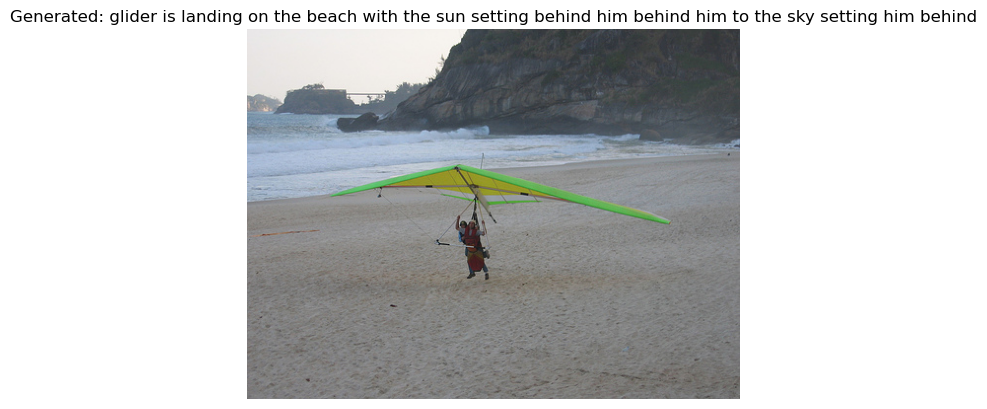

Generated Caption: glider is landing on the beach with the sun setting behind him behind him to the sky setting him behind


In [130]:
def run_caption_generation(test_img_path):
    # Load all components
    model, feature_model, wordtoix, ixtoword, max_length = setup_pipeline()
    
    test_feat = encode_image(test_img_path, feature_model).squeeze()
    
    caption = generate_caption(model, 
                             np.expand_dims(test_feat, axis=0), 
                             wordtoix, 
                             ixtoword, 
                             max_length)
    
    plt.imshow(plt.imread(test_img_path))
    plt.axis('off')
    plt.title("Generated: " + caption)
    plt.show()
    print("Generated Caption:", caption)
    
    return caption

# Example usage
test_img = "/home/abdelraheem/Abdo_Omda/Nlp/Flicker_dataset/Images/207584893_63e73c5c28.jpg"
caption = run_caption_generation(test_img)

In [131]:
# def run_caption_generation(test_img_path):
#     # Load all components
#     model, feature_model, wordtoix, ixtoword, max_length = setup_pipeline()
    
#     # Encode image
#     test_feat = encode_image(test_img_path, feature_model).squeeze()
    
#     # Generate caption
#     caption = generate_caption(model, 
#                              np.expand_dims(test_feat, axis=0), 
#                              wordtoix, 
#                              ixtoword, 
#                              max_length)
    
#     plt.imshow(plt.imread(test_img_path))
#     plt.axis('off')
#     plt.title("Generated: " + caption)
#     plt.show()
#     print("Generated Caption:", caption)
    
#     return caption

# # Example usage
# test_img = "/home/abdelraheem/Abdo_Omda/Nlp/Flicker_dataset/Images/207584893_63e73c5c28.jpg"
# caption = run_caption_generation(test_img)

Error loading model: name 'load_model' is not defined


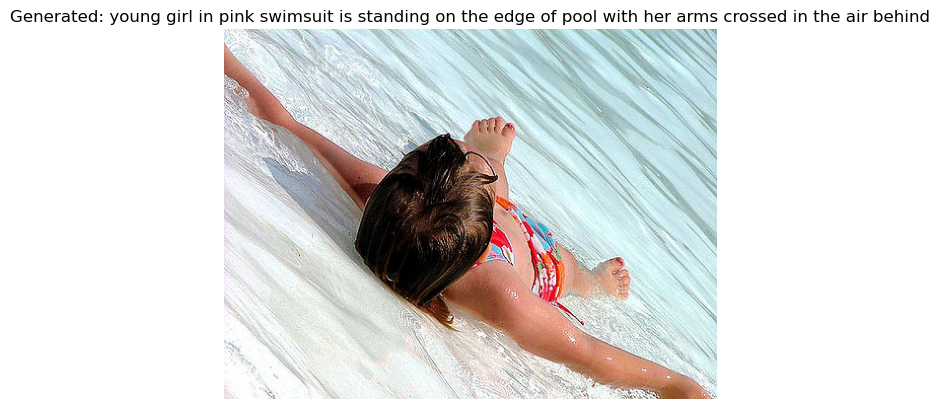

Generated Caption: young girl in pink swimsuit is standing on the edge of pool with her arms crossed in the air behind


In [133]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk, ImageEnhance

class CaptioningApp:
    def __init__(self, root):
        self.root = root
        self.root.title("🖼️ Image Caption Generator")

        # Set window size
        self.root.geometry("800x650")
        self.root.resizable(False, False)

        bg_image = Image.open("/home/abdelraheem/Abdo_Omda/Nlp/Flicker_dataset/Images/207584893_63e73c5c28.jpg").resize((800, 650))
        enhancer = ImageEnhance.Brightness(bg_image)
        bg_image = enhancer.enhance(0.6)  # Dim the background
        self.bg_image_tk = ImageTk.PhotoImage(bg_image)
        self.bg_label = tk.Label(self.root, image=self.bg_image_tk)
        self.bg_label.place(relwidth=1, relheight=1)

        self.content_frame = tk.Frame(self.root, bg="#ffffff", bd=0)
        self.content_frame.place(relx=0.5, rely=0.5, anchor="center", relwidth=0.85, relheight=0.85)

        self.upload_btn = tk.Button(
            self.content_frame, text="📤 Upload Image", command=self.upload_image,
            font=("Helvetica", 14, "bold"), bg="#2D9596", fg="white", padx=20, pady=10,
            relief="flat", cursor="hand2", bd=0
        )
        self.upload_btn.pack(pady=(30, 15))

        self.image_canvas = tk.Canvas(self.content_frame, width=300, height=300, bg="#E3F4F4", bd=2, relief="ridge")
        self.image_canvas.pack(pady=10)

        self.caption_label = tk.Label(
            self.content_frame, text="Your caption will appear here.", wraplength=600,
            font=("Helvetica", 12), bg="#ffffff", fg="#333", justify="center"
        )
        self.caption_label.pack(pady=(15, 10))

        self.image_path = None

    def upload_image(self):
        file_path = filedialog.askopenfilename(filetypes=[("Image files", "*.jpg *.jpeg *.png")])
        if file_path:
            self.image_path = file_path
            self.display_image(file_path)
            self.generate_caption(file_path)

    def display_image(self, image_path):
        img = Image.open(image_path).resize((300, 300))
        self.img_tk = ImageTk.PhotoImage(img)
        self.image_canvas.create_image(150, 150, image=self.img_tk)

    def generate_caption(self, image_path):
        caption = run_caption_generation(image_path)
        self.caption_label.config(text=f"📝 Generated Caption:\n{caption}")

if __name__ == "__main__":
    root = tk.Tk()
    app = CaptioningApp(root)
    root.mainloop()